In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
### 使用 networkx 包中的函数 LFR_benchmark_graph 生成随机图
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1 # Power-law exponent for the community size distribution 
            #S hould be >1
mu = 0.05 # Mixing parameter
avg_deg = 25 # Average Degree
max_deg = 100 # Max Degree
min_commu = 50 # Min Community Size
max_commu = 100 # Max Community Size


G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu, 
    seed=2
)

# nx.draw(G, pos=nx.spring_layout(G),node_color='r', node_size=3, edge_color='b')  # Draw the graph generated above

In [3]:
### 去掉 G 中的重边和自环 
G = nx.Graph(G) # Remove multi-edges

selfloop_edges = list(nx.selfloop_edges(G)) # a list of self loops

G.remove_edges_from(selfloop_edges) # Remove self-loops

In [4]:
### LFR 图是有内在的社群结构的，每个节点的社群存储在其 community 属性中，是一个 set
# 通过运行循环，按照内在的社群结构给每个节点一个标签 即为其 intrinsic_membership
# 为了方便 intrinsic_membership 一开始是作为一个 dict 存储的
intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
intrinsic_membership = {}
for node in range(G.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break
# intrinsic_membership = list(intrinsic_membership.values())

# 存储 list 和 clustering 格式的拷贝 省得以后需要再做类型转换了
intrinsic_list = list(intrinsic_membership.values())
from clusim.clustering import Clustering
intrinsic_clustering = Clustering(elm2clu_dict={i: [intrinsic_membership[i]] for i in intrinsic_membership.keys()})

In [5]:
### 利用 Louvain 算法进行社群识别并画图
# louvain_membership 是作为一个 dict 给出的
from community import community_louvain

louvain_membership = community_louvain.best_partition(G)

In [6]:
### 利用 InfoMap 算法进行社群识别
# 输出类型为一个 list

# Convert the NetworkX graph to an igraph graph
import igraph as ig
iG = ig.Graph.from_networkx(G)

# Perform Infomap clustering using igraph, and get the membership as a list
infomap_membership = iG.community_infomap().membership # 类型为 list
#print(f"Infomap algorithm gives {max(infomap_membership)+1} communities.")

In [7]:
### 导入计算 NMI 和 ECSim 的包 我自己封装的
from auxpack.evaluate_clustering import NMI
from auxpack.evaluate_clustering import ECSim as ECS

### 使用范例
print(NMI(louvain_membership, intrinsic_membership))
print(ECS(infomap_membership, intrinsic_membership))

1.0
1.0


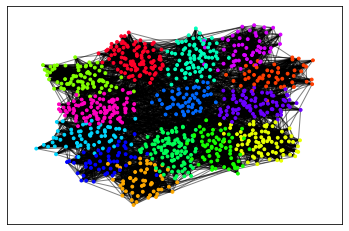

In [8]:
import matplotlib
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      node_size=8,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=intrinsic_list
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [9]:
### 导入 图嵌入评估函数 我自己封装的
from auxpack.evaluate_embd import evaluate_embd as EE

dim_rg = range(5,45,2);

In [10]:
%%time
### 1 HOPE 方法
from gem.embedding.hope import HOPE
for D in dim_rg:
    hope_model = HOPE(d=D, beta=0.01) 
    # A higher value of beta places more emphasis on capturing higher-order proximities
    hope_embd = hope_model.learn_embedding(graph=G, is_weighted=False, no_python=True)
    print(f"{D}-dim:", EE(intrinsic_list, intrinsic_clustering, hope_embd))

5-dim: [0.4337691697673152, 0.4191428035041959, 0.15761058272669645, 0.3493453023032706]
7-dim: [0.5574195284755915, 0.5820697592927032, 0.2412782388713544, 0.45038934075833154]
9-dim: [0.6366231815034171, 0.6543231005957726, 0.3021609764688609, 0.5820301679564645]
11-dim: [0.7046939535218707, 0.6787636850717114, 0.3931563908428899, 0.6042702598453729]
13-dim: [0.7162757547446967, 0.7194917763410614, 0.38417597481363314, 0.6470661617521817]
15-dim: [0.7788421252905227, 0.73664113409645, 0.4764482320901894, 0.6809863405542625]
17-dim: [0.8308448085542862, 0.8030623539683213, 0.5734822424100071, 0.7416133559280202]
19-dim: [0.8723181267396728, 0.8828704385173906, 0.6612555600381619, 0.8106360127460668]
21-dim: [0.9123095446690427, 0.9217342642384007, 0.7409105671745423, 0.8214455774690201]
23-dim: [0.9476644304198784, 0.9474992651184513, 0.830179249285115, 0.888787276914995]
25-dim: [0.9723449959508783, 0.9648159444639649, 0.9110819427486094, 0.9490451929045712]
27-dim: [0.99399457608302

In [11]:
%%time
### 2 Laplacian 方法
from gem.embedding.lap import LaplacianEigenmaps
for D in dim_rg:
    lap_model = LaplacianEigenmaps(d=D)
    lap_embd = lap_model.learn_embedding(graph=G, is_weighted=False, no_python=True)
    print(f"{D}-dim:", EE(intrinsic_list, intrinsic_clustering, lap_embd))

5-dim: [0.9232402159872183, 0.9933037286647749, 0.7216431244300494, 0.9884403535353535]
7-dim: [0.9402833103043438, 1.0, 0.8137547829994863, 1.0]
9-dim: [0.9756005949969183, 1.0, 0.9117132867132868, 1.0]
11-dim: [1.0, 1.0, 1.0, 1.0]
13-dim: [1.0, 1.0, 1.0, 1.0]
15-dim: [1.0, 1.0, 1.0, 1.0]
17-dim: [1.0, 1.0, 1.0, 1.0]
19-dim: [1.0, 1.0, 1.0, 1.0]
21-dim: [1.0, 1.0, 1.0, 1.0]
23-dim: [0.9867918488169867, 0.9677916092229673, 0.9674250450450451, 0.8930436652236653]
25-dim: [0.9879368966035568, 0.9659898482827701, 0.9690101369863015, 0.8924103521193241]
27-dim: [0.9717168126003642, 0.9679085816406431, 0.9298000000000001, 0.894235182008767]
29-dim: [0.964529504616945, 0.9652861233988528, 0.8993826147114918, 0.8886931804021524]
31-dim: [0.9660333179324478, 0.9652069787767348, 0.8914184615384615, 0.8880772249290539]
33-dim: [0.9550977786464921, 0.9474788715758008, 0.8611490416990416, 0.8568057142857143]
35-dim: [0.9519590249836472, 0.9671090063549961, 0.8675298757349822, 0.8899927577663427]
3

In [12]:
%%time
### 3 MNMF 方法

from karateclub import MNMF

K = max(intrinsic_list)+1

for D in dim_rg:
    # Create an instance of the MNMF model
    MNMF_model = MNMF(dimensions = D, clusters = K, lambd = 0.2, 
                 alpha = 0.05, beta = 0.05, iterations = 100, 
                 lower_control = 1e-15, eta = 5.0, seed = 42)

    # Fit the model to the graph
    MNMF_model.fit(G)

    # Obtain the graph embeddings
    MNMF_embd = MNMF_model.get_embedding()

    print(f"{D}-dim:", EE(intrinsic_list, intrinsic_clustering, MNMF_embd))

5-dim: [0.9065084818640887, 0.910543744823714, 0.7322259182206039, 0.7466779453832275]
7-dim: [0.9821016838117818, 0.9856029632064084, 0.972966507936508, 0.9775997464310672]
9-dim: [0.9724984113277073, 0.9822931872887689, 0.9424192924267552, 0.9369615384615384]
11-dim: [0.9776673302689833, 0.9891550266957294, 0.9515399768446037, 0.9835224867724868]
13-dim: [1.0, 1.0, 1.0, 1.0]
15-dim: [1.0, 1.0, 1.0, 1.0]
17-dim: [1.0, 1.0, 1.0, 1.0]
19-dim: [1.0, 1.0, 1.0, 1.0]
21-dim: [1.0, 1.0, 1.0, 1.0]
23-dim: [1.0, 1.0, 1.0, 1.0]
25-dim: [0.9979844993434646, 0.9979844993434646, 0.9970398493259317, 0.9970398493259317]
27-dim: [1.0, 1.0, 1.0, 1.0]
29-dim: [1.0, 1.0, 1.0, 1.0]
31-dim: [1.0, 1.0, 1.0, 1.0]
33-dim: [1.0, 1.0, 1.0, 1.0]
35-dim: [1.0, 1.0, 1.0, 1.0]
37-dim: [1.0, 1.0, 1.0, 1.0]
39-dim: [1.0, 1.0, 1.0, 1.0]
41-dim: [1.0, 1.0, 1.0, 1.0]
43-dim: [1.0, 1.0, 1.0, 1.0]
CPU times: user 34min 38s, sys: 1h 1min 27s, total: 1h 36min 6s
Wall time: 1min 24s


In [13]:
%%time
### 4 Node2Vec 方法 

from node2vec import Node2Vec

for D in dim_rg:
    # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
    node2vec_model = Node2Vec(G, dimensions=D, walk_length=16, num_walks=8, workers=32, quiet=True) #, temp_folder='test' # Use temp_folder for big graphs
    # Embed nodes 
    node2vec_fit = node2vec_model.fit(window=10, min_count=1, batch_words=16192)  
    # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed 
    # (from the Node2Vec constructor)
    node2vec_embd = []
    for i in range(G.number_of_nodes()):
        node2vec_embd.append(node2vec_fit.wv[str(i)])
    print(f"{D}-dim:", EE(intrinsic_list, intrinsic_clustering, node2vec_embd))

5-dim: [0.9940523389802913, 1.0, 0.9911876605970351, 1.0]
7-dim: [1.0, 1.0, 1.0, 1.0]
9-dim: [1.0, 1.0, 1.0, 1.0]
11-dim: [1.0, 1.0, 1.0, 1.0]
13-dim: [1.0, 1.0, 1.0, 1.0]
15-dim: [1.0, 1.0, 1.0, 1.0]
17-dim: [1.0, 1.0, 1.0, 1.0]
19-dim: [1.0, 1.0, 1.0, 1.0]
21-dim: [1.0, 1.0, 1.0, 1.0]
23-dim: [1.0, 1.0, 1.0, 1.0]
25-dim: [1.0, 1.0, 1.0, 1.0]
27-dim: [1.0, 1.0, 1.0, 1.0]
29-dim: [1.0, 1.0, 1.0, 1.0]
31-dim: [1.0, 1.0, 1.0, 1.0]
33-dim: [1.0, 1.0, 1.0, 1.0]
35-dim: [1.0, 1.0, 1.0, 1.0]
37-dim: [1.0, 1.0, 1.0, 1.0]
39-dim: [1.0, 1.0, 1.0, 1.0]
41-dim: [1.0, 1.0, 1.0, 1.0]
43-dim: [1.0, 1.0, 1.0, 1.0]
CPU times: user 29min 53s, sys: 18min 5s, total: 47min 58s
Wall time: 5min 51s


In [14]:
%%time
### 5 DeepWalk方法
from karateclub import DeepWalk
for D in dim_rg:
    model = DeepWalk(dimensions=D, walk_length=16, window_size=10)
    model.fit(G)
    deepwalk_embd = model.get_embedding()
    print(f"{D}-dim:", EE(intrinsic_list, intrinsic_clustering, deepwalk_embd))

5-dim: [0.9693568065179067, 0.9867949439489553, 0.8966148594857097, 0.9785968264113426]
7-dim: [1.0, 1.0, 1.0, 1.0]
9-dim: [1.0, 1.0, 1.0, 1.0]
11-dim: [1.0, 1.0, 1.0, 1.0]
13-dim: [1.0, 1.0, 1.0, 1.0]
15-dim: [1.0, 1.0, 1.0, 1.0]
17-dim: [1.0, 1.0, 1.0, 1.0]
19-dim: [1.0, 1.0, 1.0, 1.0]
21-dim: [1.0, 1.0, 1.0, 1.0]
23-dim: [1.0, 1.0, 1.0, 1.0]
25-dim: [1.0, 1.0, 1.0, 1.0]
27-dim: [1.0, 1.0, 1.0, 1.0]
29-dim: [1.0, 1.0, 1.0, 1.0]
31-dim: [1.0, 1.0, 1.0, 1.0]
33-dim: [1.0, 1.0, 1.0, 1.0]
35-dim: [1.0, 1.0, 1.0, 1.0]
37-dim: [1.0, 1.0, 1.0, 1.0]
39-dim: [1.0, 1.0, 1.0, 1.0]
41-dim: [1.0, 1.0, 1.0, 1.0]
43-dim: [1.0, 1.0, 1.0, 1.0]
CPU times: user 24min 38s, sys: 18min 10s, total: 42min 49s
Wall time: 33.2 s


In [15]:
%%time
### 6 LINE 方法
from ge import LINE
for D in dim_rg:
    model = LINE(G,embedding_size=D,order='first');
    model.train(batch_size=8192,epochs=50,verbose=0);# train model
    LINE_embd = model.get_embeddings();# get embedding vectors

    LINE_embd = list(LINE_embd.values())

    print(f"{D}-dim:", EE(intrinsic_list, intrinsic_clustering, LINE_embd))

2023-06-30 12:00:51.133118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 12:00:52.254691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38271 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:02:00.0, compute capability: 8.0
2023-06-30 12:00:52.257477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38271 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


5-dim: [0.9458577306422126, 0.9671897457348126, 0.8968378033189974, 0.9501959434164687]
7-dim: [1.0, 1.0, 1.0, 1.0]
9-dim: [1.0, 1.0, 1.0, 1.0]
11-dim: [1.0, 1.0, 1.0, 1.0]
13-dim: [1.0, 1.0, 1.0, 1.0]
15-dim: [1.0, 1.0, 1.0, 1.0]
17-dim: [1.0, 1.0, 1.0, 1.0]
19-dim: [1.0, 1.0, 1.0, 1.0]
21-dim: [1.0, 1.0, 1.0, 1.0]
23-dim: [1.0, 1.0, 1.0, 1.0]
25-dim: [1.0, 1.0, 1.0, 1.0]
27-dim: [1.0, 1.0, 1.0, 1.0]
29-dim: [1.0, 1.0, 1.0, 1.0]
31-dim: [1.0, 1.0, 1.0, 1.0]
33-dim: [1.0, 1.0, 1.0, 1.0]
35-dim: [1.0, 1.0, 1.0, 1.0]
37-dim: [1.0, 1.0, 1.0, 1.0]
39-dim: [1.0, 1.0, 1.0, 1.0]
41-dim: [1.0, 1.0, 1.0, 1.0]
43-dim: [1.0, 1.0, 1.0, 1.0]
CPU times: user 26min 33s, sys: 18min 21s, total: 44min 54s
Wall time: 2min 20s


In [16]:
%%time
### 7 LLE 方法
from auxpack.lle import lle
for D in dim_rg:
    lle_embd = lle(G, D)
    print(f"{D}-dim:", EE(intrinsic_list, intrinsic_clustering, lle_embd))

5-dim: [0.9980869735715006, 0.9846794907873947, 0.9970548821548821, 0.9702276740624803]
7-dim: [1.0, 1.0, 1.0, 1.0]
9-dim: [1.0, 1.0, 1.0, 1.0]
11-dim: [1.0, 1.0, 1.0, 1.0]
13-dim: [1.0, 1.0, 1.0, 1.0]
15-dim: [1.0, 1.0, 1.0, 1.0]
17-dim: [1.0, 1.0, 1.0, 1.0]
19-dim: [0.9849998602217618, 1.0, 0.9614945054945054, 1.0]
21-dim: [0.9873602430448768, 1.0, 0.9681355555555556, 1.0]
23-dim: [0.9830730309938028, 0.973623965342027, 0.9545888594164457, 0.9013428401663696]
25-dim: [0.9766687786152578, 0.9678444937021975, 0.9149016541353383, 0.8933264935064935]
27-dim: [0.9792382797034671, 1.0, 0.9226588679245283, 1.0]
29-dim: [0.9760897847673613, 1.0, 0.9451580312907432, 1.0]
31-dim: [0.9552149076886731, 1.0, 0.8653880106100796, 1.0]
33-dim: [0.9420002304669386, 0.9797848825623091, 0.8472067645374052, 0.9246596078431374]
35-dim: [0.9699687762389023, 0.9732898540453203, 0.8894000000000001, 0.8995650623885919]
37-dim: [0.9873602430448768, 0.9954284452481378, 0.9681355555555556, 0.9914363636363637]
3